C:\Users\anthony mohamed\AppData\Local\Temp\ipykernel_29836\82103815.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  core_weather = core_weather.fillna(method="ffill")


Mean Absolute Error: 2.093587987145639


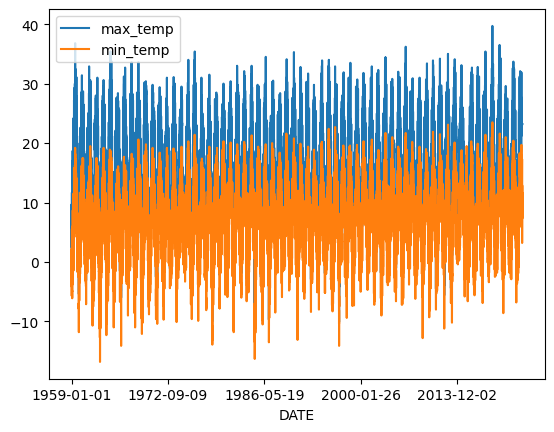

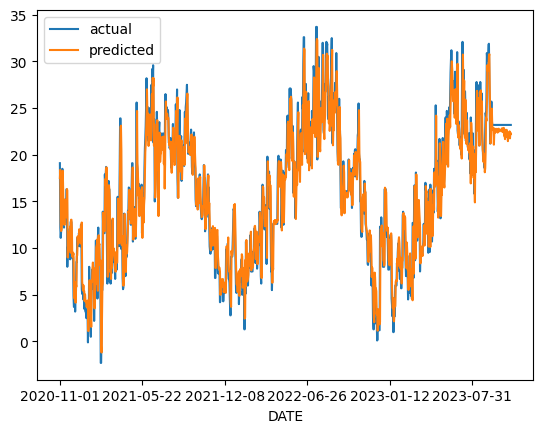

Coefficients: [-0.06876404  0.88311716  0.06249583]

Weather forecast for 2024-11-10: 
Max Temperature: 10.53°C
Min Temperature: 4.68°C
Precipitation: 2.52
It's going to rain.


c:\Users\anthony mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


{'temperature': 10.528571428571427, 'description': "It's going to rain."}

In [1]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Assuming you have the necessary data file 'dataForcast.csv'
weather = pd.read_csv('dataForcast.csv', index_col="DATE")
core_weather = weather[["PRCP", "TMAX", "TMIN"]].copy()
core_weather.columns = ["precipitation", "max_temp", "min_temp"]
core_weather["precipitation"] = core_weather["precipitation"].fillna(0)
core_weather = core_weather.fillna(method="ffill")
core_weather["target"] = core_weather["max_temp"].shift(-1)
core_weather = core_weather.ffill()
core_weather [["max_temp", "min_temp"]].plot()

reg = Ridge(alpha=0.1)
predictors = ["precipitation", "max_temp", "min_temp"]
train = core_weather.loc[:"2020-10-31"]
test = core_weather.loc["2020-11-01":]

def backtest(weather, model, predictors, start=3650, step=90):
    all_predictions = []

    for i in range(start, weather.shape[0], step):
        train_data = weather.iloc[:i, :]
        test_data = weather.iloc[i:(i+step), :]

        model.fit(train_data[predictors], train_data["target"])
        preds = model.predict(test_data[predictors])
        preds = pd.Series(preds, index=test_data.index)
        combined = pd.concat([test_data["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()
        all_predictions.append(combined)

    return pd.concat(all_predictions)

predictions = backtest(core_weather, reg, predictors)
mae = mean_absolute_error(predictions["actual"], predictions["prediction"])
print("Mean Absolute Error:", mae)

def compute_rolling(weather, horizon, col):
    label = f"rolling_{horizon}_{col}"
    weather[label] = weather[col].rolling(horizon).mean()

rolling_horizons = [3, 14]

for horizon in rolling_horizons:
    for col in predictors:
        compute_rolling(core_weather, horizon, col)

core_weather = core_weather.iloc[14:, :]
core_weather = core_weather.fillna(0)

reg.fit(train[predictors], train["target"])
predictions = reg.predict(test[predictors])
combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
combined.columns = ["actual", "predicted"]
combined.plot()
plt.show()
print("Coefficients:", reg.coef_)

core_weather["month_max"] = core_weather["max_temp"].rolling(30).max()
core_weather["month_day_max"] = core_weather["month_max"] / core_weather["max_temp"]

def predict_weather_for_date(reg, predictors, historical_data):
    date_to_predict = input("Enter the date you want to predict (YYYY-MM-DD): ")

    new_row = pd.DataFrame(index=[date_to_predict], columns=predictors).fillna(0)
    prediction = reg.predict(new_row.values.reshape(1, -1))[0]

    if date_to_predict in historical_data.index:
        max_temp = historical_data.loc[date_to_predict, "max_temp"]
        min_temp = historical_data.loc[date_to_predict, "min_temp"]
        prcp = historical_data.loc[date_to_predict, "precipitation"]
    else:
        same_day_data = historical_data[pd.to_datetime(historical_data.index).dayofyear == pd.to_datetime(date_to_predict).dayofyear]
        max_temp = same_day_data["max_temp"].mean()
        min_temp = same_day_data["min_temp"].mean()
        prcp = same_day_data["precipitation"].mean()

# Check if it's going to rain
    if prcp > 0:
        precipitation_status = "It's going to rain."
    else:
        precipitation_status = "It's dry."

    print("\nWeather forecast for {}: \nMax Temperature: {:.2f}°C\nMin Temperature: {:.2f}°C\nPrecipitation: {:.2f}\n{}".format(date_to_predict, max_temp, min_temp, prcp, precipitation_status))

    return {
        
        'temperature': max_temp,
        'description': precipitation_status,   }

# Example usage
predict_weather_for_date(reg, predictors, core_weather)
